This notebook based on this articles http://drivendata.co/blog/benchmark-cold-start-lstm-deep-learning/

In [1]:
%matplotlib inline

# plotting
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data loading

### Training Data

In [2]:
data_path = Path('..', '..', 'data', 'raw')
consumption_train = pd.read_csv(data_path / 'consumption_train.csv', 
                                index_col=0, parse_dates=['timestamp'])
consumption_train.head()

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [3]:
def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    assert num_training_hours == train_df.shape[0]
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)
    
describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


That's a lot of data! In order speed up development and facilitate rapid prototyping, let's reduce the training set. Since all of the training series are the same length, we'll uniformly sample a subset of series. The size of our resulting reduced data will be controlled by frac_series_to_use

In [4]:
# choose subset of series for training
frac_series_to_use = 0.01

rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = consumption_train.series_id.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)

training_series = series_ids[series_mask]

# reduce training data to series subset
consumption_train = consumption_train[consumption_train.series_id.isin(training_series)]

# describe the reduced set
describe_training_data(consumption_train)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


### Test Data

In [5]:
cold_start_test = pd.read_csv(data_path / 'cold_start_test.csv', 
                              index_col=0, parse_dates=['timestamp'])
cold_start_test.head()

,series_id,timestamp,consumption,temperature
0,102781,2013-02-27 00:00:00,15295.740389,17.00
1,102781,2013-02-27 01:00:00,15163.209562,18.25
2,102781,2013-02-27 02:00:00,15022.264079,18.00
3,102781,2013-02-27 03:00:00,15370.420458,17.00
4,102781,2013-02-27 04:00:00,15303.103213,16.90


In [6]:
submission_format = pd.read_csv(data_path / 'submission_format.csv',
                                index_col='pred_id',
                                parse_dates=['timestamp'])
submission_format.head()

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,0.0,daily
1,102781,2013-03-04,20.034375,0.0,daily
2,102781,2013-03-05,19.189583,0.0,daily
3,102781,2013-03-06,18.397917,0.0,daily
4,102781,2013-03-07,20.762500,0.0,daily


## EDA

In [7]:
# confirm that every series asks for only one type of prediction
assert all(1 == submission_format.groupby('series_id').prediction_window.nunique())

# use the first() prediction window value from a series_id so as not to overcount
submission_format.groupby('series_id').prediction_window.first().value_counts()

hourly    242
weekly    192
daily     191
Name: prediction_window, dtype: int64

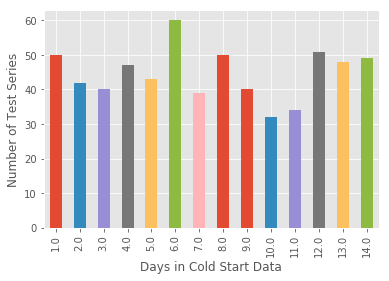

In [8]:
ax = (cold_start_test.groupby('series_id').count()
                                           .timestamp
                                           .divide(24)
                                           .value_counts()
                                           .sort_index()
                                           .plot.bar())
ax.set_xlabel('Days in Cold Start Data')
ax.set_ylabel('Number of Test Series')
plt.show()

In [9]:
# add prediction_window to the test data
pred_windows = submission_format[['series_id', 'prediction_window']].drop_duplicates()
cold_start_test = cold_start_test.merge(pred_windows, on='series_id')

num_cold_start_days_provided = (cold_start_test.groupby('series_id')
                                               .prediction_window
                                               .value_counts()
                                               .divide(24))

num_cold_start_days_provided.head()

series_id  prediction_window
100004     weekly                4.0
100010     hourly               12.0
100012     hourly               10.0
100020     weekly               13.0
100028     daily                13.0
Name: prediction_window, dtype: float64

In [10]:
def _count_cold_start_days(subdf):
    """ Get the number of times a certain cold-start period
        appears in the data.
    """
    return (subdf.series_id
                 .value_counts()
                 .divide(24)  # hours to days 
                 .value_counts())

cold_start_occurrence = (cold_start_test.groupby('prediction_window')
                                        .apply(_count_cold_start_days))

cold_start_occurrence.head()

prediction_window      
daily              1.0     19
                   8.0     18
                   13.0    18
                   6.0     15
                   9.0     15
Name: series_id, dtype: int64

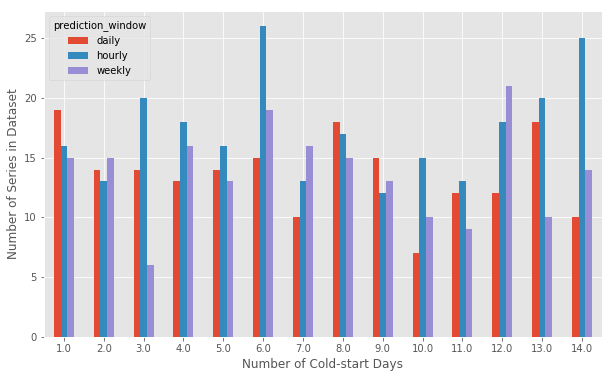

In [11]:
ax = cold_start_occurrence.unstack(0).plot.bar(figsize=(10, 6),
                                               rot=0)

ax.set_xlabel('Number of Cold-start Days')
ax.set_ylabel('Number of Series in Dataset');

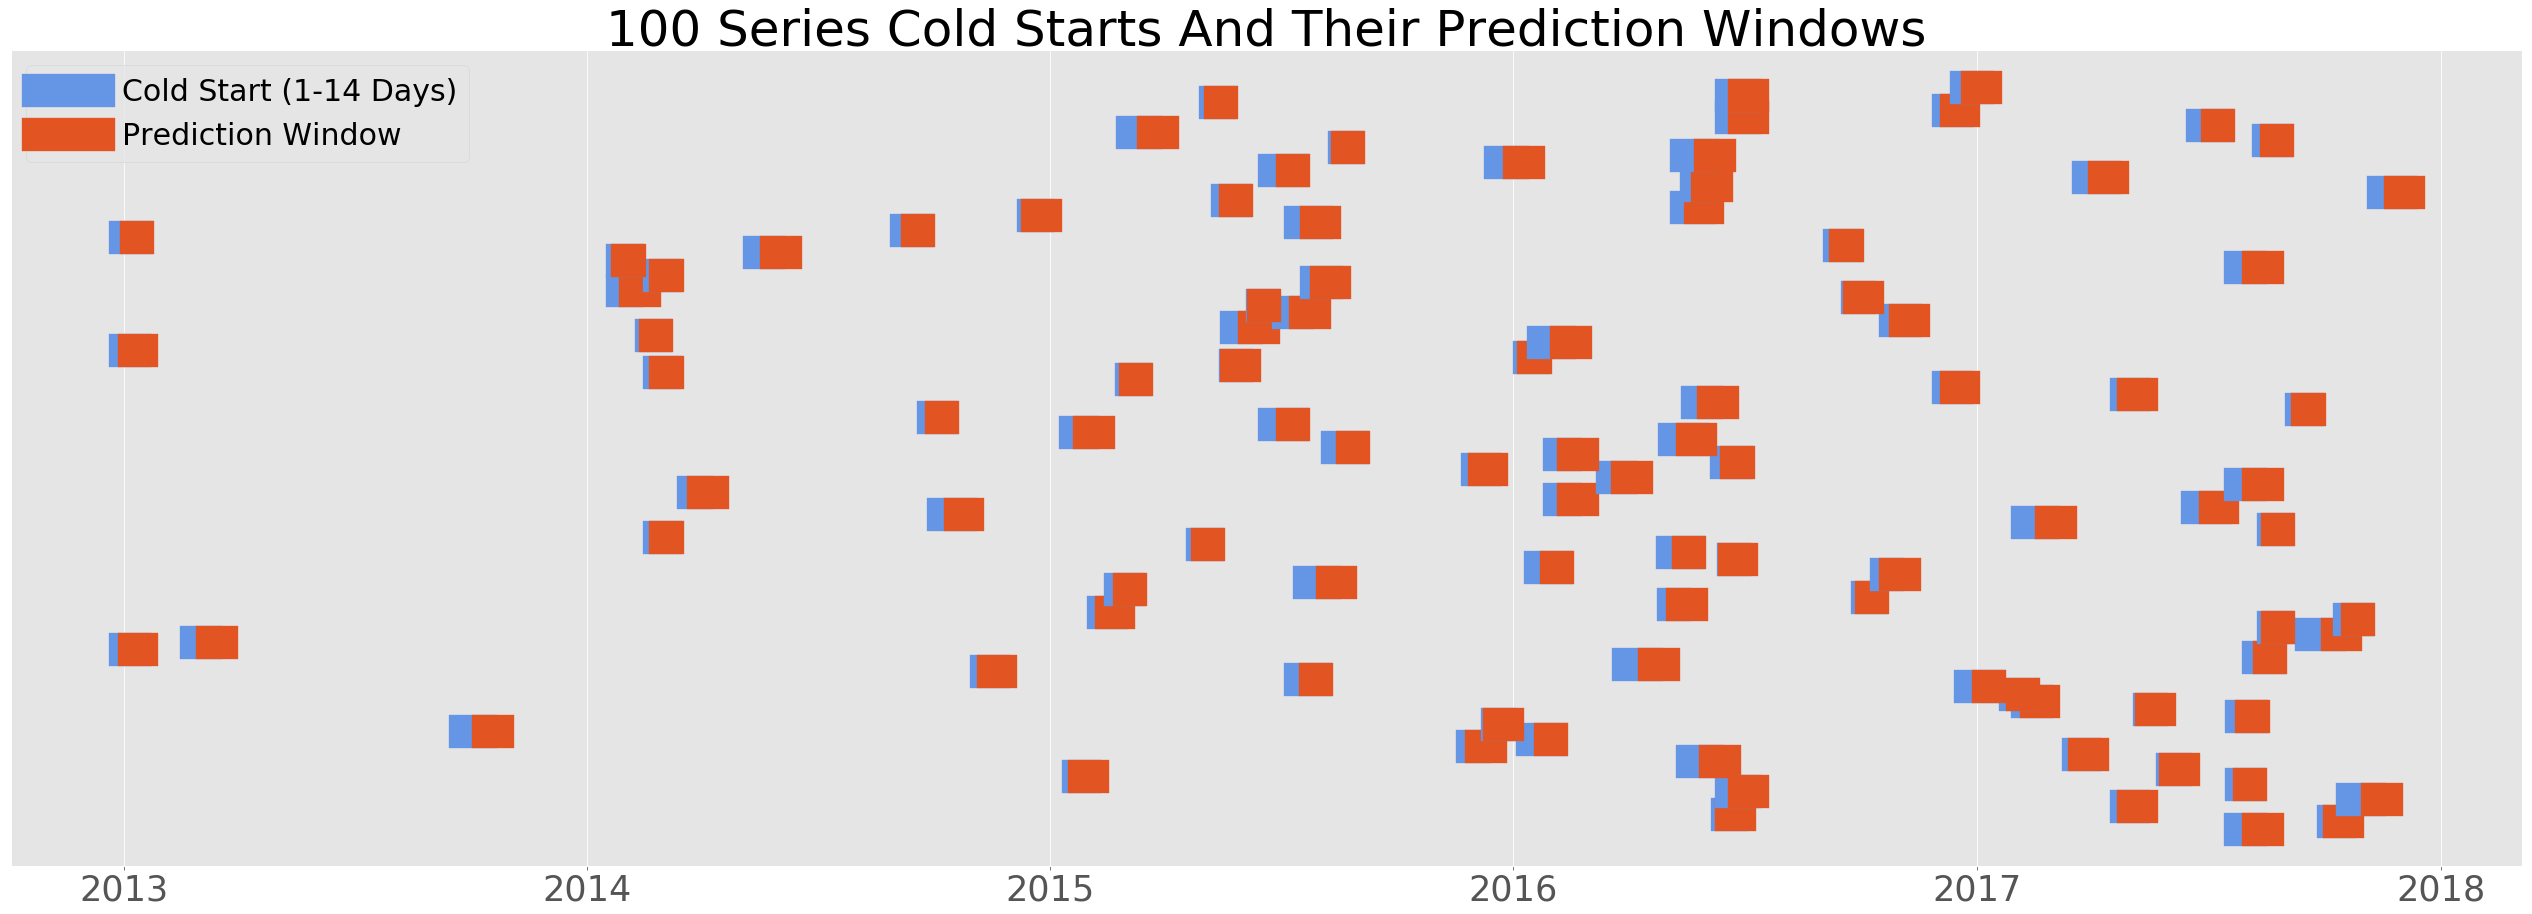

In [15]:
# visualize the cold start and prediction windows
num_to_plot = 100

fig, ax = plt.subplots(figsize=(45, 15))

cold_start_map = {'hourly': 1, 'daily': 7, 'weekly': 14}

rng = np.random.RandomState(seed=5425)
series_to_plot = rng.choice(cold_start_test.series_id.unique(), num_to_plot)

for i, series_id in enumerate(series_to_plot):
    # get relevant information about the test series from coldstart data
    series_data = cold_start_test[cold_start_test.series_id == series_id]
    start_cold = series_data.timestamp.min()
    stop_cold = series_data.timestamp.max()
    
    # get prediction stop from submission format
    start_preds = submission_format[submission_format.series_id == series_id].timestamp.min()
    stop_preds = submission_format[submission_format.series_id == series_id].timestamp.max()
    
    # plot the cold start and prediction window relative sizes
    ax.plot([start_cold, stop_cold], [i, i], c='#6496e5', linewidth=num_to_plot / 3)
    ax.plot([start_preds, stop_preds], [i, i], c='#e25522', linewidth=num_to_plot / 3)

# the y tick labels don't mean anything so turn them off
ax.set_yticks([])
plt.tick_params(labelsize=35)
plt.legend(['Cold Start (1-14 Days)', 
            'Prediction Window'], 
           fontsize=30)

plt.title(f'{num_to_plot} Series Cold Starts And Their Prediction Windows', fontsize=50);

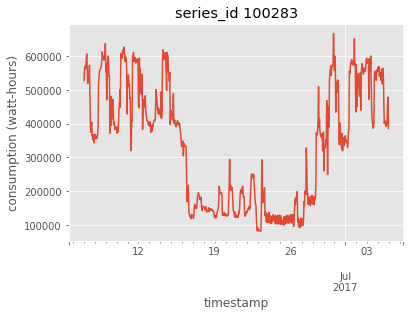

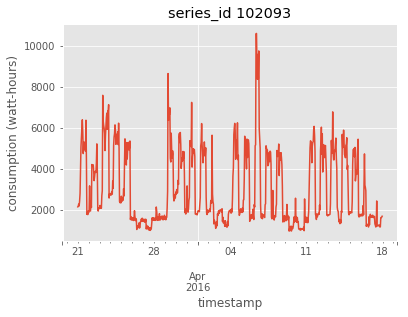

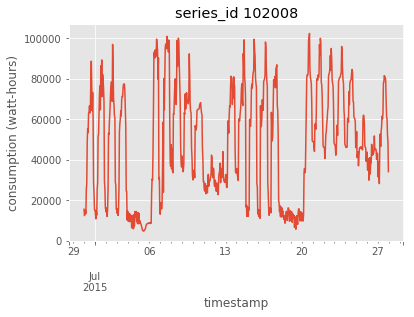

In [16]:
# plot a few consumption patterns
series_to_plot = rng.choice(consumption_train.series_id.unique(), 3)

for ser_id in series_to_plot:
    ser_data = consumption_train[consumption_train.series_id == ser_id]
    ax = ser_data.plot(x='timestamp',
                       y='consumption', 
                       title=f"series_id {int(ser_id)}",
                       legend=False)
    plt.ylabel('consumption (watt-hours)')
    plt.show()

In [17]:
(consumption_train.groupby('series_id')
                  .timestamp
                  .apply(lambda x: x.max() - x.min())
                  .value_counts())

27 days 23:00:00    10
Name: timestamp, dtype: int64

## Detail check the prediction windows

In [21]:
from datetime import datetime

In [36]:
timedeltas = []
for ser_id, submission_df in submission_format.groupby('series_id'):
    col_df = cold_start_test[cold_start_test.series_id == ser_id]
    start_cold = col_df.timestamp.min()
    stop_cold = col_df.timestamp.max()
    
    # get prediction stop from submission format
    start_preds = submission_df.timestamp.min()
    stop_preds = submission_df.timestamp.max()
    
    timedelta = start_preds - stop_cold
    
    timedeltas.append(timedelta.days)
    
    print(stop_cold - start_cold, '-', stop_preds - start_preds, '-',timedelta, submission_df.prediction_window.iloc[0])
#     print('Stop cold:', stop_cold, ' - Start Pred:', start_preds)

3 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
11 days 23:00:00 - 0 days 23:00:00 - 0 days 01:00:00 hourly
9 days 23:00:00 - 0 days 23:00:00 - 0 days 01:00:00 hourly
12 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
12 days 23:00:00 - 6 days 00:00:00 - 0 days 01:00:00 daily
4 days 23:00:00 - 0 days 23:00:00 - 0 days 01:00:00 hourly
9 days 23:00:00 - 0 days 23:00:00 - 0 days 01:00:00 hourly
5 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
8 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
2 days 23:00:00 - 6 days 00:00:00 - 0 days 01:00:00 daily
7 days 23:00:00 - 6 days 00:00:00 - 0 days 01:00:00 daily
4 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
6 days 23:00:00 - 6 days 00:00:00 - 0 days 01:00:00 daily
3 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
10 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
0 days 23:00:00 - 7 days 00:00:00 - 6 days 01:00:00 weekly
7 days 23:00:00 - 6 days 00:00:00 - 0 days 01:00:00 dail

In [17]:
submission_format.series_id.nunique()

625

In [31]:
np.unique(timedeltas)

array([0, 6])

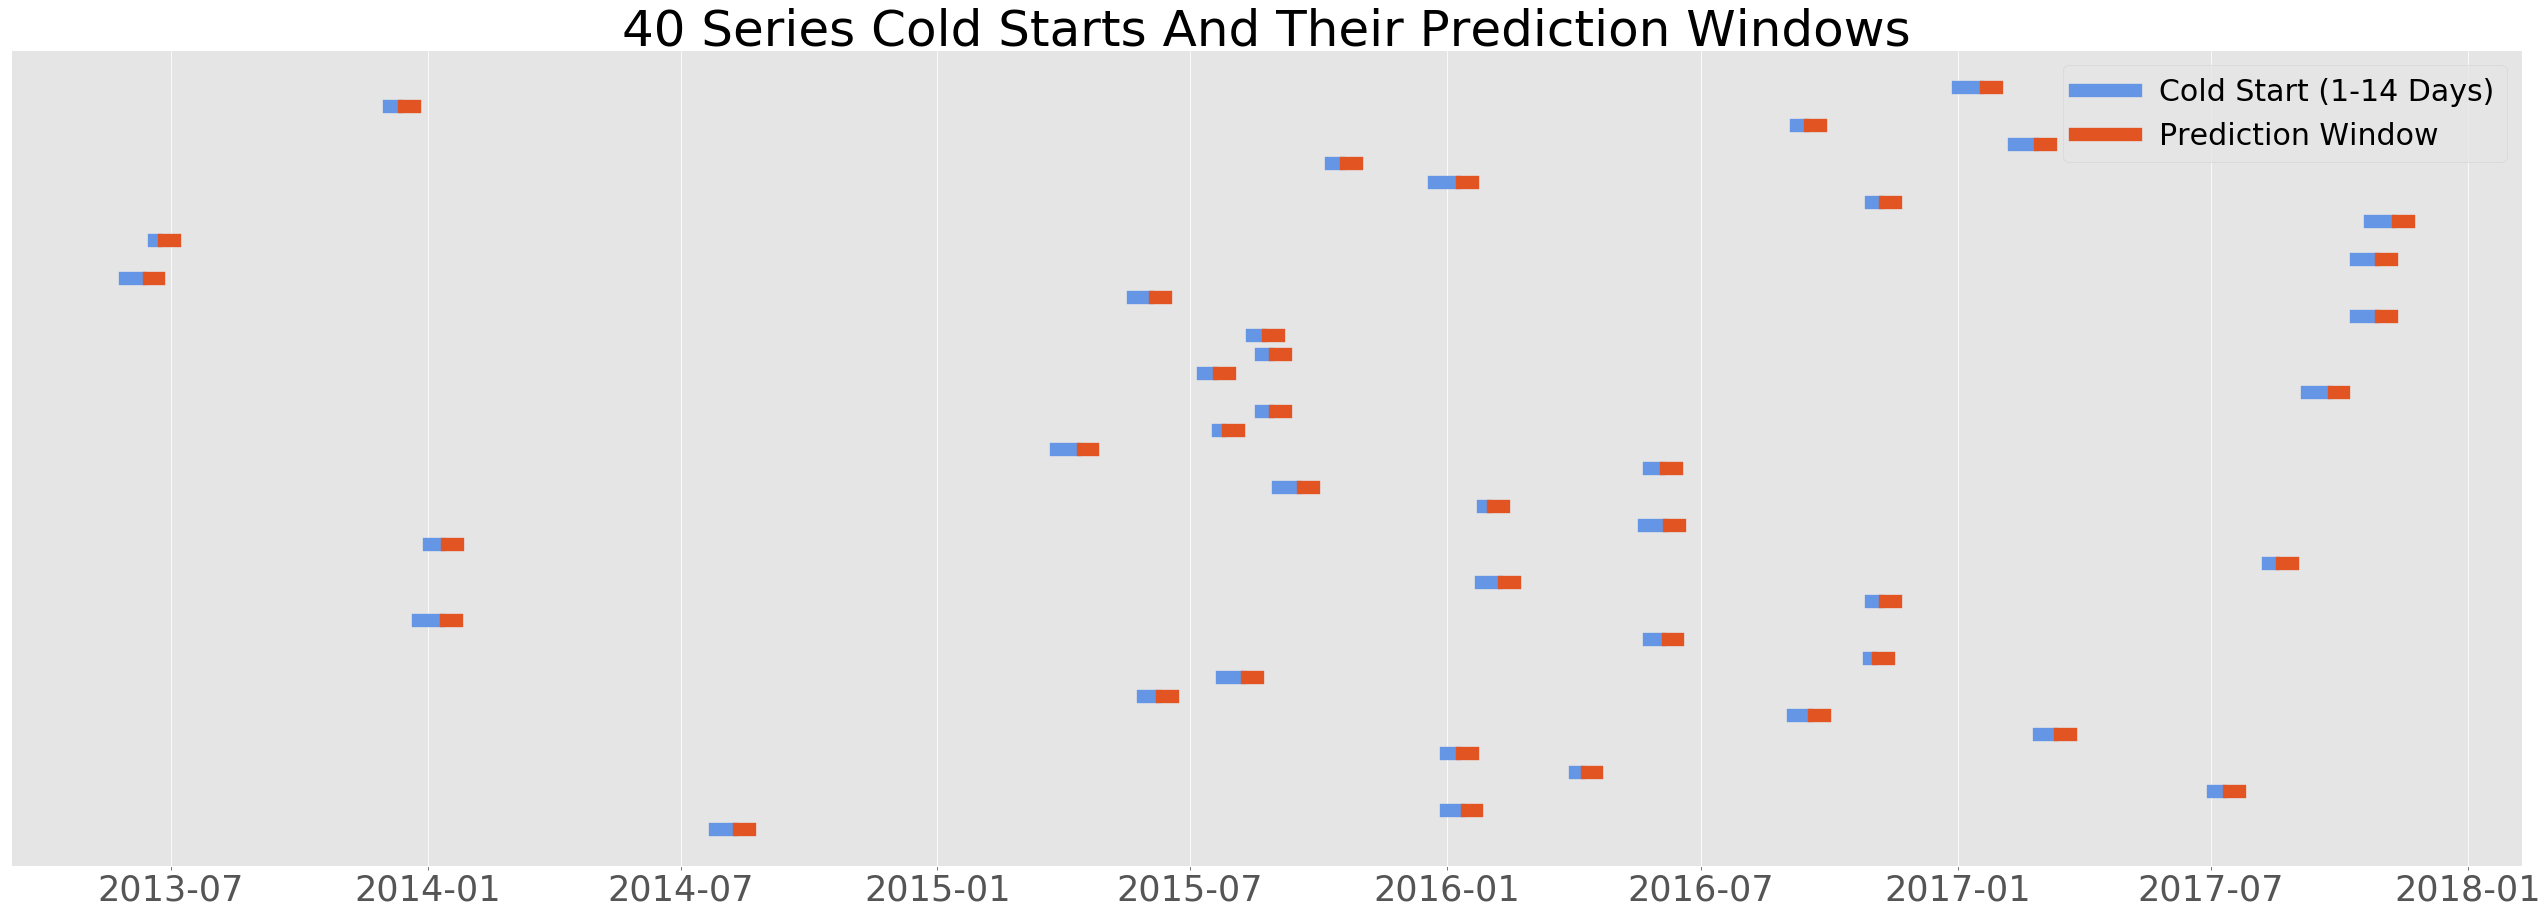

In [34]:
# visualize the cold start and prediction windows
num_to_plot = 40

fig, ax = plt.subplots(figsize=(45, 15))

cold_start_map = {'hourly': 1, 'daily': 7, 'weekly': 14}

rng = np.random.RandomState(seed=5425)
series_to_plot = rng.choice(cold_start_test[cold_start_test.prediction_window == 'weekly'].series_id.unique(), num_to_plot)

for i, series_id in enumerate(series_to_plot):
    # get relevant information about the test series from coldstart data
    series_data = cold_start_test[cold_start_test.series_id == series_id]
    start_cold = series_data.timestamp.min()
    stop_cold = series_data.timestamp.max()
    
    # get prediction stop from submission format
    start_preds = submission_format[submission_format.series_id == series_id].timestamp.min()
    stop_preds = submission_format[submission_format.series_id == series_id].timestamp.max()
    
    # plot the cold start and prediction window relative sizes
    ax.plot([start_cold, stop_cold], [i, i], c='#6496e5', linewidth=num_to_plot / 3)
    ax.plot([start_preds, stop_preds], [i, i], c='#e25522', linewidth=num_to_plot / 3)

# the y tick labels don't mean anything so turn them off
ax.set_yticks([])
plt.tick_params(labelsize=35)
plt.legend(['Cold Start (1-14 Days)', 
            'Prediction Window'], 
           fontsize=30)

plt.title(f'{num_to_plot} Series Cold Starts And Their Prediction Windows', fontsize=50);